# Project

### 1 Load Packages

In [1]:
# ========================TensorFlow========================
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.2.0-rc2


In [9]:
# ========================General========================
import os
import io
import sys
import time
import json
import joblib
import pandas as pd
import numpy as np
import requests
import statistics
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
# ========================Ploting========================
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
# ========================Data Preprocessing========================
from sklearn import preprocessing
# Encoding
from sklearn.preprocessing import LabelEncoder
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
# Data Split
from sklearn.model_selection import train_test_split
# ========================Modeling========================
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Decision Tree & Random Forest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# KMeans
from sklearn.cluster import KMeans
# ========================Evaluation========================
from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef, f1_score
# ========================Deep Learning========================
# MLP
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, AlphaDropout
# ================================================

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

### 2 Load dataset

In [11]:
# load movie
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df = df[df.release_date.notnull()]
    df = df[df.release_date.str.contains("^\d{4}\-\d{2}.")]
    df = df[df.release_date>="1970-01-01"]
    df['release_year'] = pd.to_datetime(df['release_date']).apply(lambda x: int(x.year) if x==x else None)
    df['release_month'] = pd.to_datetime(df['release_date']).apply(lambda x: int(x.month) if x==x else None)
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [12]:
# load movie credits
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [13]:
# Columns that existed in IMDB version of the dataset and are gone.
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']

# Columns in TMDb that had direct equivalents in the IMDB version. 
# These columns can be used with old kernels just by changing the names
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}


def safe_access(container, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan


def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])


def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])


def convert_to_original_format(movies, credits):
    # Converts TMDb data to make it as compatible as possible with kernels built on the original version of the data.
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['companies_1'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['companies_2'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['companies_3'] = tmdb_movies['production_companies'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [14]:
# movies_path = '/content/drive/My Drive/Colab Notebooks/NEU-7390 Advances Data Sci Architecture/movie_data.csv'
# credits_path = '/content/drive/My Drive/Colab Notebooks/NEU-7390 Advances Data Sci Architecture/movie_credits.csv'

In [41]:
# movies = load_tmdb_movies(movies_path)
# credits = load_tmdb_credits(credits_path)
# raw_data =convert_to_original_format(movies, credits)

movies = load_tmdb_movies("../../PreditMovieSuccess/movie_data_edited.csv")
credits = load_tmdb_credits("../../PreditMovieSuccess/movie_credits.csv")
df =convert_to_original_format(movies, credits)

### 3 Data Preprocessing
*   Handling Missing Values
*   Drop Duplication Values
*   Drop Outliers

#### 3.1 Handling Missing Values

In [42]:
raw_data = df[df['budget'] > 0]

In [43]:
def missing_value_table(df):
    total_missing = df.isnull().sum().sort_values(ascending=False)
    percent = round(((df.isnull().sum()/len(df))*100),2).sort_values(ascending=False)
    missing_data = pd.concat([total_missing, percent], axis=1, keys=['total Missing', 'Percent(%)'])
    print("=====Missing Value Check Table=====")
    print(missing_data)

In [44]:
missing_value_table(raw_data)

=====Missing Value Check Table=====
                      total Missing  Percent(%)
homepage                       5455       72.11
companies_3                    4590       60.67
companies_2                    2808       37.12
tagline                        2058       27.20
actor_3_name                   1073       14.18
actor_2_name                    909       12.02
companies_1                     900       11.90
director_name                   670        8.86
actor_1_name                    581        7.68
country                         348        4.60
language                        188        2.49
overview                         39        0.52
duration                          5        0.07
original_title                    0        0.00
id                                0        0.00
plot_keywords                     0        0.00
production_companies              0        0.00
genres                            0        0.00
popularity                        0        0.00
spok

In [45]:
# drop homepage & tagline
raw_data.drop(['homepage','tagline'], axis=1, inplace=True)

#### 3.2 Drop Duplication Values and Unseen Features

In [46]:
# Drop Duplication Values
drop_duplicates_subset = ('budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title','overview', 'popularity','release_date', 'gross', 'duration','status','movie_title','vote_average','num_voted_users')
raw_data.drop_duplicates(subset=drop_duplicates_subset, keep='first', inplace=True)

In [47]:
# Drop features that only know after movie release
raw_data.drop(['num_voted_users', 'popularity'], axis=1, inplace=True)

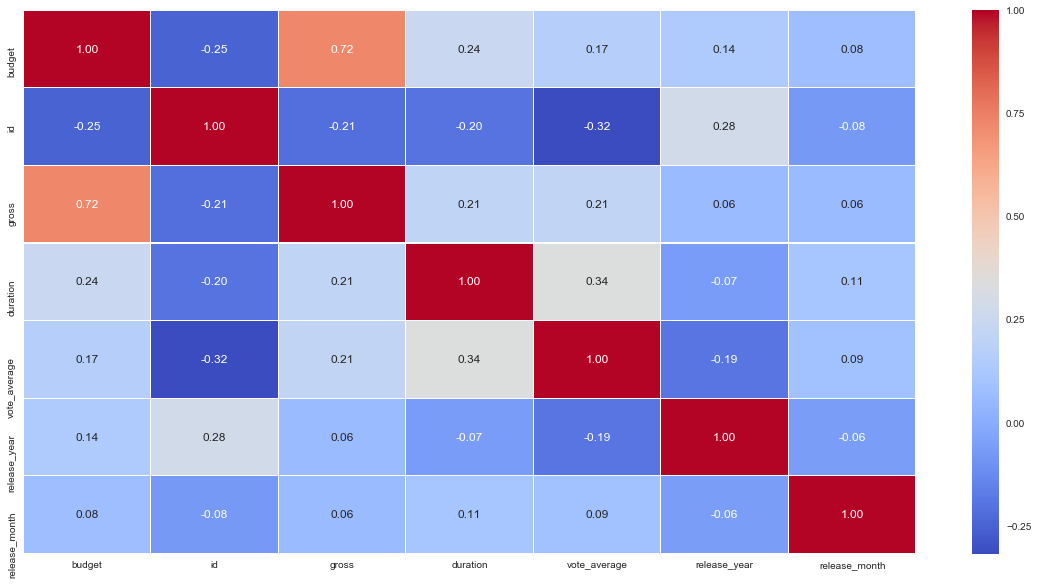

In [48]:
# Correlation matrix between numerical values
plt.figure(figsize = (20,10))
g = sns.heatmap(raw_data[list(raw_data)].corr(),annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

#### 3.3 Drop Outliers

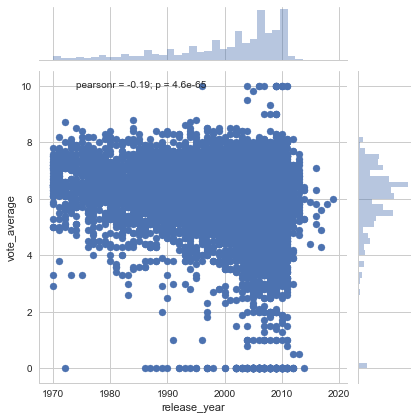

In [49]:
# release_year and vote_average
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
sns.jointplot(x="release_year", y="vote_average", data=raw_data)
plt.show()

In [50]:
# Drop rows in dataset containing 0 and below vote average
before_rows = len(raw_data)
raw_data = raw_data[raw_data['vote_average'] > 0]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before_rows-len(raw_data), len(raw_data)))

Delete 165 rows;
Current Total rows: 7400


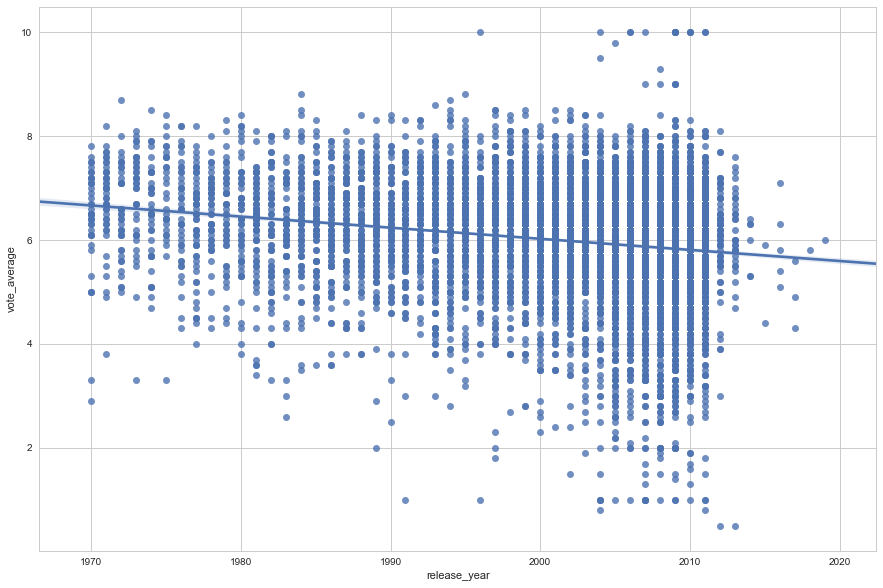

In [51]:
plt.figure(figsize = (15,10))
sns.set(style="whitegrid")
sns.regplot(x="release_year", y="vote_average", data=raw_data)
plt.show()

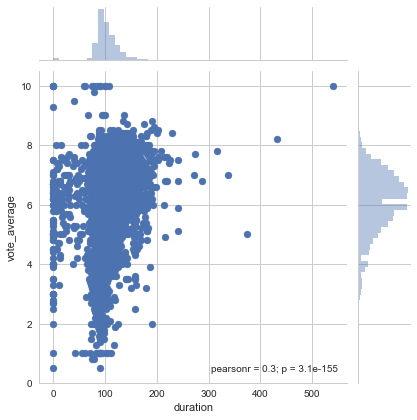

In [52]:
# Duration and vote_average
plt.figure(figsize = (15,10))
sns.set(style="whitegrid")
sns.jointplot(x="duration", y="vote_average", data=raw_data)
plt.show()

In [53]:
# Most of directors decide to make 90-120 mins movie, 0-10 duration is unlikely possible
# Drop rows in dataset of which duration > 10 and duration < 600
before_rows = len(raw_data)
raw_data = raw_data[10<raw_data['duration']]
raw_data = raw_data[raw_data['duration']<600]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before_rows-len(raw_data), len(raw_data)))

Delete 85 rows;
Current Total rows: 7315


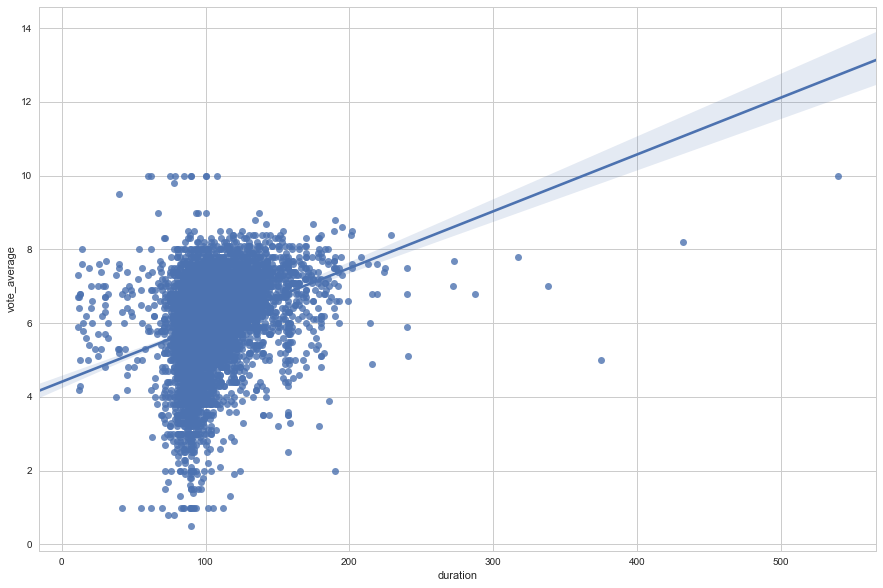

In [54]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
sns.regplot(x="duration", y="vote_average", data=raw_data)
plt.show()

In [55]:
missing_value_table(raw_data)

=====Missing Value Check Table=====
                      total Missing  Percent(%)
companies_3                    4350       59.47
companies_2                    2585       35.34
actor_3_name                   1023       13.98
actor_2_name                    868       11.87
companies_1                     729        9.97
director_name                   640        8.75
actor_1_name                    551        7.53
country                         261        3.57
language                        120        1.64
overview                         13        0.18
production_countries              0        0.00
genres                            0        0.00
id                                0        0.00
plot_keywords                     0        0.00
original_title                    0        0.00
production_companies              0        0.00
spoken_languages                  0        0.00
release_date                      0        0.00
gross                             0        0.00
dura

### 4 Data Wrangling: Define a movie is successful or unsuccessful and edit features
*   Define Label
*   Budget
*   Release Year
*   Duration
*   Genres
*   Director
*   Actor
*   Company

#### 4.1 Define Label

In [56]:
# Total columns fot dataset
raw_data.columns

Index(['budget', 'genres', 'id', 'plot_keywords', 'language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'gross', 'duration', 'spoken_languages', 'status',
       'movie_title', 'vote_average', 'release_year', 'release_month',
       'country', 'director_name', 'actor_1_name', 'actor_2_name',
       'actor_3_name', 'companies_1', 'companies_2', 'companies_3'],
      dtype='object')

In [57]:
raw_data.describe(percentiles=[.10,.25,.5,.75,.9,.99], include=['float','int'])

,budget,id,gross,duration,vote_average,release_year,release_month
count,7.315000e+03,7315.000000,7.315000e+03,7315.000000,7315.000000,7315.000000,7315.000000
mean,2.078810e+07,24791.978947,5.038520e+07,104.838141,6.027109,2000.067943,6.679426
std,3.227801e+07,20612.878079,1.242341e+08,23.651808,1.158989,10.179368,3.491410
min,1.000000e+00,5.000000,0.000000e+00,11.000000,0.500000,1970.000000,1.000000
10%,2.898576e+05,1921.400000,0.000000e+00,85.000000,4.500000,1984.000000,2.000000
25%,2.000000e+06,9608.500000,0.000000e+00,91.000000,5.400000,1995.000000,4.000000
50%,8.500000e+06,16608.000000,3.011195e+06,100.000000,6.200000,2003.000000,7.000000
75%,2.500000e+07,39867.500000,4.159436e+07,114.000000,6.800000,2008.000000,10.000000
90%,5.800000e+07,57419.800000,1.498823e+08,131.000000,7.300000,2010.000000,11.000000
99%,1.550000e+08,72766.860000,6.230111e+08,180.000000,8.200000,2012.000000,12.000000


In [59]:
# For this kernel, successful movies is a movie which got vote_score more than vote_score mean
raw_data['success'] = raw_data['vote_average'].map(lambda s :1  if s >= raw_data['vote_average'].mean() else 0)
raw_data.success.value_counts()

1    3994
0    3321
Name: success, dtype: int64

In [60]:
# For this kernel, successful movies is a movie which got vote_score more than vote_score mean
# raw_data['success'] = raw_data['vote_average'].map(lambda s :1  if s >= raw_data['vote_average'].mean() else 0)
# raw_data.success.value_counts()
for i in raw_data.index:
    gross = float(raw_data.at[i, 'gross'])
    budget = float(raw_data.at[i, 'budget'])
    raw_data.at[i, 'success'] = 1 if raw_data.at[i, 'success'] == 1 and gross / budget >= 1.2 else 0
raw_data.success.value_counts()

0    5305
1    2010
Name: success, dtype: int64

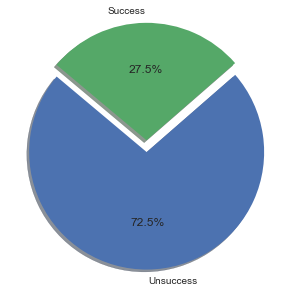

In [61]:
# Data to plot
plt.figure(figsize=(5,5))
labels = ["Unsuccess","Success"]
sizes = raw_data['success'].value_counts(sort=False)
explode = (0.1,0)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

#### 4.2 Budget

In [62]:
raw_data.budget=raw_data.budget.astype(int)

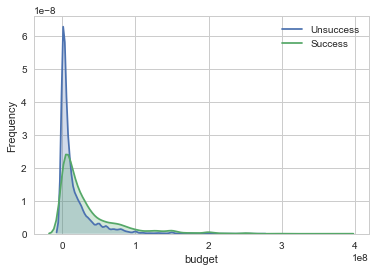

In [63]:
# budget distibution
g = sns.kdeplot(raw_data.budget[(raw_data["success"] == 0) ], shade = True)
g = sns.kdeplot(raw_data.budget[(raw_data["success"] == 1) ], shade= True)
g.set_xlabel("budget")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

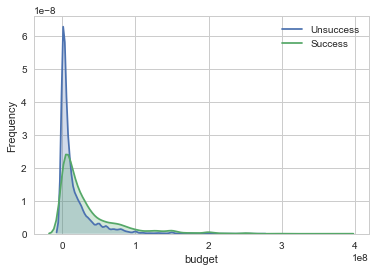

In [64]:
# Non-zero budget distibution
g = sns.kdeplot(raw_data.budget[raw_data.budget>0][(raw_data["success"] == 0)], shade = True)
g = sns.kdeplot(raw_data.budget[raw_data.budget>0][(raw_data["success"] == 1)], shade= True)
g.set_xlabel("budget")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

In [65]:
print("Percent of zero budget: {}%".format(round((raw_data.budget==0).sum()/len(raw_data)*100, 2)))

Percent of zero budget: 0.0%


In [66]:
# Based on common sence, no moive can be made with zero budget. So drop rows with zero budget
before_rows = len(raw_data)
raw_data = raw_data[raw_data.budget!=0]
print('Delete {} rows;\nCurrent rows: {}'.format(before_rows-len(raw_data), len(raw_data)))

Delete 0 rows;
Current rows: 7315


In [67]:
# The Q1,Q2(median),Q3,95% of budget of non-zero movies
non_zero_budget_Q1 = raw_data.budget[raw_data.budget>0].quantile(0.25)
non_zero_budget_median = raw_data.budget[raw_data.budget>0].quantile(0.5)
non_zero_budget_Q3 = raw_data.budget[raw_data.budget>0].quantile(0.75)
non_zero_budget_95 = raw_data.budget[raw_data.budget>0].quantile(0.95)

In [68]:
'''
Create new feature of budget
0 < Budget < Q1 => VeryLowBudget
Q1 <= Budget < Median =>LowBudget
Median <= Budget < Q3 => MedBudget
Q3 <= Budget < 95% => HighBudget
95% <= Budget => VeryHighBudget
'''
raw_data['VeryLowBudget'] = raw_data['budget'].map(lambda s: 1 if 0< s < non_zero_budget_Q1 else 0)
raw_data['LowBudget'] = raw_data['budget'].map(lambda s: 1 if non_zero_budget_Q1 <= s < non_zero_budget_median else 0)
raw_data['MedBudget'] = raw_data['budget'].map(lambda s: 1 if  non_zero_budget_median <= s < non_zero_budget_Q3 else 0)
raw_data['HighBudget'] = raw_data['budget'].map(lambda s: 1 if non_zero_budget_Q3 <= s < non_zero_budget_95 else 0)
raw_data['VeryHighBudget'] = raw_data['budget'].map(lambda s: 1 if s >= non_zero_budget_95 else 0)

#### 4.3 Release Year

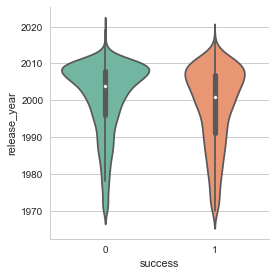

In [69]:
# Release Year Distribution
g = sns.factorplot(y="release_year",x="success",data=raw_data,kind="violin", palette = "Set2")

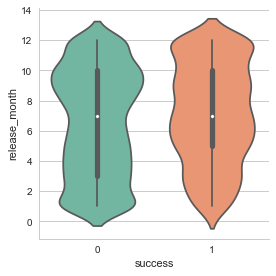

In [70]:
# Release Month Distribution
g = sns.factorplot(y="release_month",x="success",data=raw_data,kind="violin", palette = "Set2")

#### 4.4 Duration

In [71]:
before = len(raw_data)
raw_data = raw_data[np.isfinite(raw_data['duration'])]
print('Delete {} rows;\nCurrent Total rows: {}'.format(before-len(raw_data), len(raw_data)))

Delete 0 rows;
Current Total rows: 7315


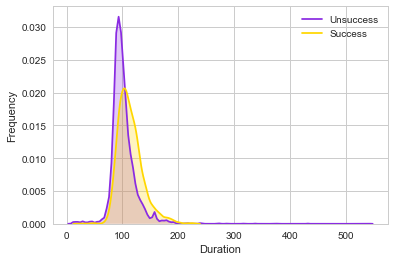

In [72]:
# duration distibution
g = sns.kdeplot(raw_data.duration[(raw_data["success"] == 0) ], color="blueviolet", shade = True)
g = sns.kdeplot(raw_data.duration[(raw_data["success"] == 1) ], ax =g, color="gold", shade= True)
g.set_xlabel("Duration")
g.set_ylabel("Frequency")
g = g.legend(["Unsuccess","Success"])

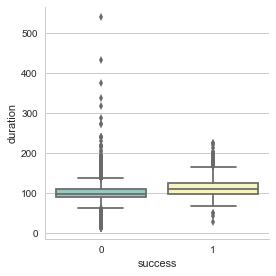

In [73]:
# duration distibution by success
g = sns.factorplot(x="success", y = "duration",data = raw_data, kind="box", palette = "Set3")

In [74]:
'''
Based on common sence
duration <90          => Short Movie
90 <= duration < 120  => Normal Movie
120 <= duration       => Long Movie
'''
raw_data['ShortMovie'] = raw_data['duration'].map(lambda s: 1 if s < 90 else 0)
raw_data['NormalMovie'] = raw_data['duration'].map(lambda s: 1 if 90 <= s < 120 else 0)
raw_data['LongMovie'] = raw_data['duration'].map(lambda s: 1 if s >= 120 else 0)

#### 4.5 Genres
Since a movie may have multiple genres, we will use one-hot encoding to transform the column of Genres

In [75]:
raw_data.genres.head()

14        Drama|Action|Crime
60          Comedy|Drama|War
62         Drama|History|War
63         Drama|History|War
65    Drama|History|Thriller
Name: genres, dtype: object

In [76]:
def Obtain_list_Occurences(data, column):
    # Obtaining list of column
    listOcc = []
    for i in data[column]:
        split_genre = list(map(str, i.split('|')))
        for j in split_genre:
            if j not in listOcc:
                listOcc.append(j)
    return listOcc

In [77]:
genre = []
genre = Obtain_list_Occurences(raw_data, "genres")
# Drop empty string
genre = list(filter(lambda x:len(x)>0, genre))

In [78]:
# Encoding genre
for w in genre:
    raw_data[w] = raw_data['genres'].map(lambda s: 1 if w in str(s) else 0)

In [79]:
raw_data.loc[:,genre].head()

,Drama,Action,Crime,Comedy,War,History,Thriller,Romance,Horror,Mystery,Documentary,Music,Adventure,Science Fiction,Western,Animation,Family,Fantasy,TV Movie
14,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
62,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
63,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
65,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


#### 4.6 Director

In [80]:
raw_data.director_name.fillna('unknown', inplace=True)

In [81]:
def to_frequency_table(data):
    frequency = {}
    for key in data:
        if key in frequency and key:
            frequency[key] += 1
        else:
            frequency[key] = 1
    return frequency

In [82]:
director_dic = to_frequency_table(raw_data['director_name'])
director_list = list(director_dic.items())
director_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
director_list=list(filter(lambda x:x[0]!='unknown', director_list))

In [83]:
# Funtion to find top xx in list
def Top(List, top_num):
    Top = list()
    for i in range(0, top_num):
        Top.append(List[i][0])
    return Top

In [84]:
# Encoding Top 50 director
top_list = Top(director_list, 100)
for w in top_list:
    raw_data[w] = raw_data['director_name'].map(lambda s: 1 if w in str(s) else 0)
# Encoding non-Top 50 director in 'other_director' columns
raw_data['other_director'] = raw_data['director_name'].map(lambda x:1 if x not in top_list else 0)
print("Total movies of top directors: {};\nTotal movies of non-top directors: {};\nTotal movies: {}.".format(raw_data[top_list].sum().sum(), raw_data.other_director.sum(), len(raw_data)))

Total movies of top directors: 607;
Total movies of non-top directors: 6709;
Total movies: 7315.


#### 4.7 Actor

In [85]:
# Fill none value in 3 actor columns
raw_data.actor_1_name.fillna('unknown',inplace=True)
raw_data.actor_2_name.fillna('unknown',inplace=True)
raw_data.actor_3_name.fillna('unknown',inplace=True)

In [86]:
raw_data[['actor_1_name','actor_2_name','actor_3_name']]

,actor_1_name,actor_2_name,actor_3_name
14,Tom Hanks,Robin Wright,Gary Sinise
60,Christian Ulmen,Moritz Bleibtreu,Martina Gedeck
62,Jennifer Grey,Patrick Swayze,Jerry Orbach
63,Harrison Ford,Sean Connery,Denholm Elliott
65,Abel Jacquin,Francisco Rabal,unknown
77,Robert De Niro,Jodie Foster,Albert Brooks
78,Franka Potente,Moritz Bleibtreu,Herbert Knaup
90,Jonathan Rhys Meyers,Scarlett Johansson,Emily Mortimer
98,unknown,unknown,unknown
110,Anders W. Berthelsen,Iben Hjejle,Jesper Asholt


In [87]:
# # Combine 3 columns and sort the occurrence
# raw_data['actors_name'] = raw_data[['actor_1_name','actor_2_name','actor_3_name']].apply(lambda x:'|'.join(x), axis=1)
# actor_occ = []
# actor_occ = Obtain_list_Occurences(raw_data,"actors_name")
# # Drop 'unknown' string
# actor_occ = list(filter(lambda x:x!='unknown', actor_occ))

In [88]:
# actor_dic = to_frequency_table(actor_occ)
# actor_list = list(actor_dic.items())
# actor_list.sort(key=lambda tup:tup[1],reverse=True)
# # drop 'unknown' item
# actor_list=list(filter(lambda x:x[0]!='unknown', actor_list))

In [89]:
# Encoding actor column
# for w in actor_occ:
#     raw_data[w] = raw_data['actors_name'].map(lambda s: 1 if w in str(s) else 0)

#### 4.8 Company

In [90]:
# Fill none value in 3 actor columns
raw_data['companies_1'].fillna('unknown',inplace=True)
raw_data['companies_2'].fillna('unknown',inplace=True)
raw_data['companies_3'].fillna('unknown',inplace=True)

In [91]:
company_dic = to_frequency_table(raw_data['companies_1'])
company_list = list(company_dic.items())
company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
company_list_1=list(filter(lambda x:x[0]!='unknown', company_list))

In [92]:
company_dic = to_frequency_table(raw_data['companies_2'])
company_list = list(company_dic.items())
company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
company_list_2=list(filter(lambda x:x[0]!='unknown', company_list))

In [93]:
company_dic = to_frequency_table(raw_data['companies_2'])
company_list = list(company_dic.items())
company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
company_list_3=list(filter(lambda x:x[0]!='unknown', company_list))

In [94]:
# Combine all company in one list
full_company_list=sorted(company_list_1+company_list_2+company_list_3)
company_dict={}
for a,b in full_company_list:
    if a not in company_dict.keys():
        company_dict[a] = b
    elif a in company_dict.keys():
        company_dict[a] = company_dict.get(a) + b

combined_company_list = list(company_dict.items())
combined_company_list.sort(key=lambda tup:tup[1],reverse=True)
# drop 'unknown' item
combined_company_list=list(filter(lambda x:x[0]!='unknown', combined_company_list))

In [95]:
total=0
for a,b in combined_company_list:
    total += b

top_index = 0
top_count = 0
for a,b in combined_company_list:
    if b >= 20:
        top_count += b
        top_index += 1
    else:
        break
print(top_index)
print(len(combined_company_list))
print(combined_company_list[top_index])

80
4750
('DC Comics', 19)


In [96]:
# Create company columns
toplist = Top(combined_company_list, top_index)
for w in toplist:
    raw_data[w] = 0

In [97]:
# Encoding Top company
for w in toplist:
    raw_data[w][raw_data[w]!=1] = raw_data['companies_1'].map(lambda x: 1 if x in w else 0)
for w in toplist:
    raw_data[w][raw_data[w]!=1] = raw_data['companies_2'].map(lambda x: 1 if x in w else 0)
for w in toplist:
    raw_data[w][raw_data[w]!=1] = raw_data['companies_3'].map(lambda x: 1 if x in w else 0)

In [98]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7315 entries, 14 to 43074
Columns: 235 entries, budget to Zentropa Entertainments
dtypes: float64(2), int64(214), object(19)
memory usage: 13.5+ MB


#### 4.9 Drop Columns

In [99]:
raw_data.drop(['budget','genres','id','plot_keywords','language','original_title','overview',
               'production_companies','production_countries','release_date','duration','spoken_languages','status','movie_title','vote_average','country',
               'director_name',
               'actor_1_name','actor_2_name','actor_3_name',
               'companies_1','companies_2','companies_3'], axis=1, inplace=True)

In [100]:
# Check missing value
total = raw_data.isnull().sum().sort_values(ascending=False)
percent = (raw_data.isnull().sum()/raw_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
Zentropa Entertainments,0,0.0
William Castle,0,0.0
Jonathan Kaplan,0,0.0
Jan Švankmajer,0,0.0
Tsui Hark,0,0.0


### 5 Modeling
*   Define Useful Functions
*   Split Data
*   K-Nearest Neighbors
*   Decision Tree
*   Random Forest
*   Gradient Boosting
*   Conclusion Model Performance
*   Model Test

#### 5.0 Define Useful Functions

In [101]:
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

In [102]:
def model_selection(clf, x_train_all, y_train_all, x_train, y_train, x_test, y_test):
    clf.fit(x_train,y_train)
    score_all=cross_val_score(clf, x_train_all, y_train_all, cv=5)
    avg_score=score_all.mean()
    print("Accuracy Score for 5-fold Cross Validation: {}".format(round(avg_score,2)))
    y_test_pred=clf.predict(x_test)
    cm = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cm, normalize = False, target_names = ['failed','success'],title = "Confusion Matrix over Test Data")

#### 5.1 Split Data

In [103]:
# Split data into train and test set
data = raw_data
y = data['success']
y = np.array(y).reshape(-1,1)
x = data.drop('success',axis=1)
# release_year and release_month has fixed range => Min-Max Normalization
minmax = MinMaxScaler()
x[['release_year','release_month']] = minmax.fit_transform(x[['release_year','release_month']])

In [104]:
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,random_state=10, test_size=.25)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11, test_size=0.25)

In [105]:
print('x_train: {}; y_train: {}.'.format(x_train_all.shape, y_train_all.shape))
print('x_train: {}; y_train: {}.'.format(x_train.shape, y_train.shape))
print('x_valid: {}; y_valid: {}.'.format(x_valid.shape, y_valid.shape))
print('x_test: {}; y_test: {}.'.format(x_test.shape, y_test.shape))

x_train: (5486, 211); y_train: (5486, 1).
x_train: (4114, 211); y_train: (4114, 1).
x_valid: (1372, 211); y_valid: (1372, 1).
x_test: (1829, 211); y_test: (1829, 1).


#### 5.2 K-Nearest Neighbors

In [106]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=2,
           weights='uniform')

Accuracy Score for 5-fold Cross Validation: 0.82


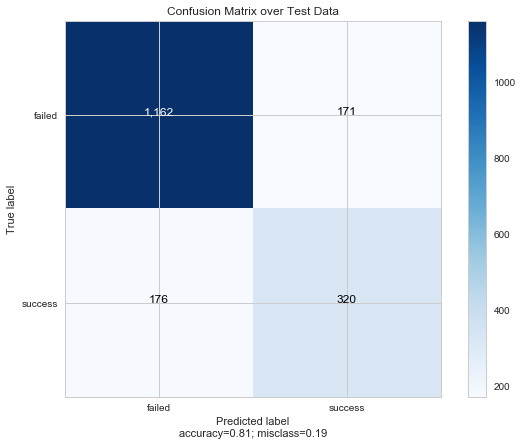

In [107]:
model_selection(knn, x_train_all, y_train_all, x_train, y_train, x_test, y_test)

#### 5.3 Decision Tree

In [108]:
decision_tree = DecisionTreeClassifier(criterion='entropy',max_depth=20, min_samples_leaf=10)
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Accuracy Score for 5-fold Cross Validation: 0.85


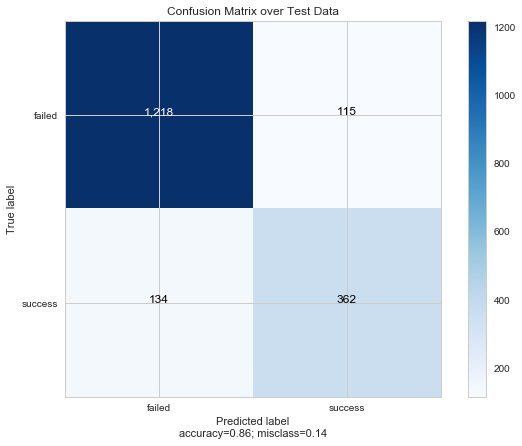

In [109]:
model_selection(decision_tree, x_train_all, y_train_all, x_train, y_train, x_test, y_test)

####  DNN

In [110]:
dnn_model=Sequential([
                  Dense(64, input_dim=x_train.shape[1],activation='relu'),
                  Dense(32, activation='relu'),
                  Dense(16, activation='sigmoid'),
                  AlphaDropout(rate=0.5),
                  Dense(1, activation='sigmoid')])

Instructions for updating:
Colocations handled automatically by placer.


In [111]:
dnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                13568     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 16,193
Trainable params: 16,193
Non-trainable params: 0
_________________________________________________________________


In [112]:
dnn_model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=['accuracy'])

In [113]:
# callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]
dnn_model.fit(x_train, y_train, batch_size=512, epochs=50, validation_data=(x_valid,y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 4114 samples, validate on 1372 samples
Epoch 1/50
4114/4114 [==============================] - 1s 129us/step - loss: 0.8960 - acc: 0.4733 - val_loss: 0.7594 - val_acc: 0.2872
Epoch 2/50
4114/4114 [==============================] - 0s 10us/step - loss: 0.8651 - acc: 0.4971 - val_loss: 0.7386 - val_acc: 0.4125
Epoch 3/50
4114/4114 [==============================] - 0s 11us/step - loss: 0.8492 - acc: 0.5134 - val_loss: 0.7268 - val_acc: 0.7172
Epoch 4/50
4114/4114 [==============================] - 0s 10us/step - loss: 0.8106 - acc: 0.5425 - val_loss: 0.7482 - val_acc: 0.7172
Epoch 5/50
4114/4114 [==============================] - 0s 10us/step - loss: 0.7954 - acc: 0.5659 - val_loss: 0.6992 - val_acc: 0.7172
Epoch 6/50
4114/4114 [==============================] - 0s 11us/step - loss: 0.7661 - acc: 0.5807 - val_loss: 0.6874 - val_acc: 0.7172
Epoch 7/50
4114/4114 [==============================] - 0s 9us/step - loss: 0.7478 - acc: 0.5

In [114]:
y_pred = dnn_model.predict_classes(x_test)
accuracy_score(y_test,y_pred)

0.7288135593220338

In [115]:
dnn_model.evaluate(x_test, y_test, verbose=1)

1829/1829 [==============================] - 0s 18us/step


[0.5895723306526572, 0.7288135593546226]